#### Import Libraries

In [1]:
import os
import time
import torch
from PIL import Image
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Dataset 

#### Data Preprocessing

In [2]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.8, 1.25)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# preprocessing of images
class BallsDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.labels = labels
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = self.labels[index]
        return (image, label)


#### Load Training Data

In [64]:
dataset_dir = 'Dataset/balls'
train_dir = os.path.join(dataset_dir,"train")
images = []
labels = []
class_names = []
for class_id, class_name in enumerate(os.listdir(train_dir)):
    class_names.append(class_name)
    for filename in os.listdir(train_dir+"/"+class_name):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(train_dir,class_name, filename)
            images.append(image_path)
            labels.append(class_id)

In [4]:
# create train dataset
import random
data = list(zip(images,labels))
random.shuffle(data)
images,labels = zip(*data)
train_ds = BallsDataset(images, labels, transform)
train_dl = DataLoader(train_ds, batch_size=128)
print(len(train_ds), len(train_dl))

3595 29


#### Load Validation Data

In [5]:
dataset_dir = 'Dataset/balls'
valid_dir = os.path.join(dataset_dir,"valid")
valid_images = []
valid_labels = []

for class_id,class_name in enumerate(os.listdir(valid_dir )):
    for filename in os.listdir(valid_dir+"/"+class_name):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(valid_dir,class_name, filename)
            valid_images.append(image_path)
            valid_labels.append(class_id)

In [6]:
# create test dataset
import random
valid_data = list(zip(valid_images,valid_labels))
random.shuffle(valid_data)
valid_images,valid_labels = zip(*valid_data)
valid_ds = BallsDataset(valid_images, valid_labels,transform)
valid_dl = DataLoader(valid_ds, batch_size=128)
print(len(valid_ds), len(valid_dl))

150 2


#### Load Test Data

In [21]:
dataset_dir = 'Dataset/balls'
test_dir = os.path.join(dataset_dir, "test")
test_images = []
test_labels = []

for class_id,class_name in enumerate(os.listdir(test_dir )):
    for filename in os.listdir(test_dir+"/"+class_name):
        if filename.endswith('.jpeg') or filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(test_dir,class_name, filename)
            test_images.append(image_path)
            test_labels.append(class_id)

In [22]:
# create test dataset
import random
test_data = list(zip(test_images,test_labels))
random.shuffle(test_data)
test_images,test_labels = zip(*test_data)
test_ds = BallsDataset(test_images, test_labels,transform)
test_dl = DataLoader(test_ds, batch_size=128)
print(len(test_ds), len(test_dl))

150 2


#### Create Pytorch Model

In [9]:
class BallsModelNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # onvolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), padding=1)

        # conected layers
        self.fc1 = nn.Linear(in_features= 128 * 4 * 4, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=30)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        X = F.dropout(X, 0.5, training=self.training)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        X = F.dropout(X, 0.5, training=self.training)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        X = F.dropout(X, 0.5, training=self.training)

        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2)
        X = F.dropout(X, 0.5, training=self.training)
        
        # print(X.shape)
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X.log_softmax(dim=-1)


net = BallsModelNet()

In [10]:
from torchinfo import summary
summary(net)

Layer (type:depth-idx)                   Param #
BallsModelNet                            --
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Linear: 1-5                            204,900
├─Linear: 1-6                            5,050
├─Linear: 1-7                            1,530
Total params: 308,920
Trainable params: 308,920
Non-trainable params: 0

##### Define Optimizer

In [11]:
opt = optim.Adam(net.parameters(), lr=0.001)

##### Define Loss Function

In [12]:
loss_func = nn.CrossEntropyLoss()

#### Train the model

In [13]:
def save_checkpoint(model, optimizer, epoch, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)


In [37]:
# Create instance of the model
losses = []
accuracies = []
epoches = 100

best_valid_acc, best_train_acc = -1, -1


In [72]:
model, opt, start_epoch = load_checkpoint(net, opt, 'checkpoints/checkpoint_69_0.985_0.803.pth')
print(f"Starting epochs: {start_epoch}")

# Model Training...
for epoch in range(start_epoch, epoches):
    start = time.time()
    epoch_loss = 0
    epoch_accuracy = 0

    valid_epoch_loss = 0
    valid_epoch_accuracy = 0

    for X, y in train_dl:

        preds = net(X)

        loss = loss_func(preds, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss

    

    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)


    start = time.time()
    with torch.no_grad():
        for valid_X, valid_y in valid_dl:
            valid_preds = net(valid_X)
            valid_loss = loss_func(valid_preds, valid_y)

            valid_epoch_loss += valid_loss            
            valid_accuracy = ((valid_preds.argmax(dim=-1) == valid_y).float().mean())
            valid_epoch_accuracy += valid_accuracy

    valid_epoch_accuracy = valid_epoch_accuracy/len(valid_dl)
    valid_epoch_loss = valid_epoch_loss / len(valid_dl)

    if  epoch_accuracy > best_train_acc and valid_epoch_accuracy > best_valid_acc:
        best_valid_acc = valid_epoch_accuracy
        best_train_acc = epoch_accuracy
        save_checkpoint(net, opt, epoch, f'checkpoints/checkpoint_{epoch}_{best_train_acc:.3f}_{best_valid_acc:.3f}.pth')

    print("time: {}, Epoch: {}, train loss: {:.4f}, Valid loss: {:.3f}, train acc: {:.4f}, Valid acc: {:.3f}".format(time.time() - start, epoch+1, epoch_loss, valid_epoch_loss, epoch_accuracy, valid_epoch_accuracy))

Starting epochs: 69
time: 0.36328911781311035, Epoch: 70, train loss: 0.0491, Valid loss: 2.342, train acc: 0.9860, Valid acc: 0.723
time: 0.3693861961364746, Epoch: 71, train loss: 0.0433, Valid loss: 2.025, train acc: 0.9873, Valid acc: 0.750
time: 0.3657059669494629, Epoch: 72, train loss: 0.0415, Valid loss: 2.053, train acc: 0.9855, Valid acc: 0.765
time: 0.36605381965637207, Epoch: 73, train loss: 0.0413, Valid loss: 2.647, train acc: 0.9846, Valid acc: 0.765
time: 0.374589204788208, Epoch: 74, train loss: 0.0536, Valid loss: 2.087, train acc: 0.9836, Valid acc: 0.784
time: 0.43338465690612793, Epoch: 75, train loss: 0.0613, Valid loss: 2.451, train acc: 0.9822, Valid acc: 0.761
time: 0.39742374420166016, Epoch: 76, train loss: 0.0441, Valid loss: 2.123, train acc: 0.9857, Valid acc: 0.772
time: 0.36408329010009766, Epoch: 77, train loss: 0.0442, Valid loss: 2.282, train acc: 0.9860, Valid acc: 0.773
time: 0.3677380084991455, Epoch: 78, train loss: 0.0399, Valid loss: 2.025, trai

#### Test data

In [71]:
test_epoch_loss = 0
test_epoch_accuracy = 0

actual_label, predict_label = [], []

start = time.time()
with torch.no_grad():
    for test_X, test_y in test_dl:
        test_preds = net(test_X)
        test_loss = loss_func(test_preds, test_y)

        test_epoch_loss += test_loss            
        test_accuracy = ((test_preds.argmax(dim=-1) == test_y).float().mean())
        test_epoch_accuracy += test_accuracy
        actual_label.append(test_y)
        predict_label.append(test_preds.argmax(dim=-1))


test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
test_epoch_loss = test_epoch_loss / len(test_dl)

print("time: {}, test loss: {:.4f}, test acc: {:.4f}\n".format(time.time() - start, test_epoch_loss, test_epoch_accuracy))


time: 0.44457221031188965, test loss: 2.1705, test acc: 0.7081



#### Evaluation Matrix

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns



predicted_labels = predict_label[0].numpy()
ground_truth_labels = actual_label[0].numpy()

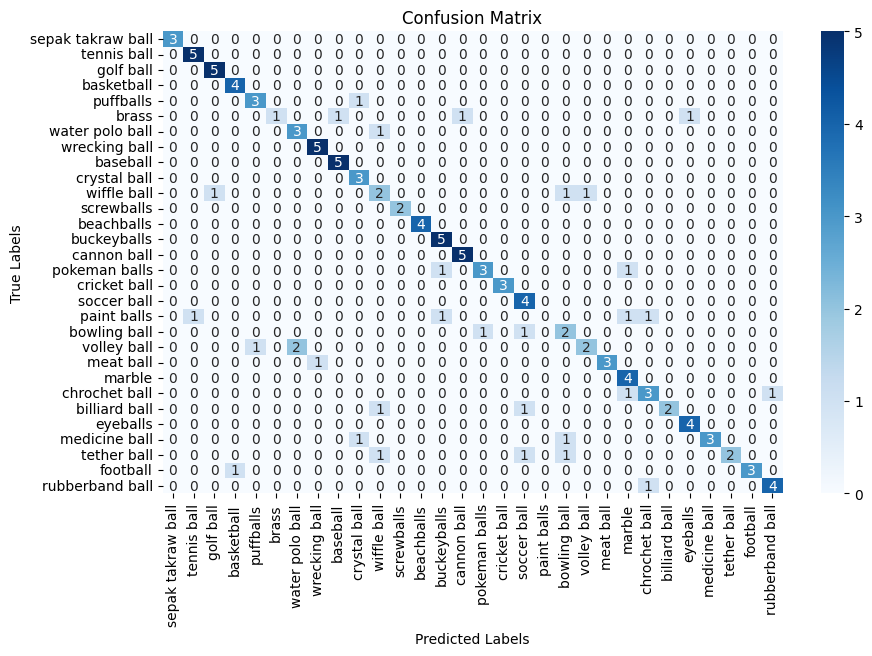

In [56]:
cm = confusion_matrix(ground_truth_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
report = classification_report(ground_truth_labels, predicted_labels, target_names=class_names)

print(report)

                   precision    recall  f1-score   support

sepak takraw ball       1.00      1.00      1.00         3
      tennis ball       0.83      1.00      0.91         5
        golf ball       0.83      1.00      0.91         5
       basketball       0.80      1.00      0.89         4
        puffballs       0.75      0.75      0.75         4
            brass       1.00      0.25      0.40         4
  water polo ball       0.60      0.75      0.67         4
    wrecking ball       0.83      1.00      0.91         5
         baseball       0.83      1.00      0.91         5
     crystal ball       0.60      1.00      0.75         3
      wiffle ball       0.40      0.40      0.40         5
       screwballs       1.00      1.00      1.00         2
       beachballs       1.00      1.00      1.00         4
      buckeyballs       0.71      1.00      0.83         5
      cannon ball       0.83      1.00      0.91         5
    pokeman balls       0.75      0.60      0.67       

/home/ahmad-mujtaba/Ahmad_Mujtaba/python_work/Tinygrad_Learning_Projects/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahmad-mujtaba/Ahmad_Mujtaba/python_work/Tinygrad_Learning_Projects/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahmad-mujtaba/Ahmad_Mujtaba/python_work/Tinygrad_Learning_Projects/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with

#### Save the model

In [73]:
model_path = "model/balls_model_pytorch.pth"
torch.save(net.state_dict(), model_path)

#### load the best checkpoints

In [34]:
def load_checkpoint(model, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

model, _, _ = load_checkpoint(net, opt, 'checkpoints/checkpoint_44_0.977_0.819.pth')
model.eval()

BallsModelNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=30, bias=True)
)

#### Test on unseen data

In [75]:
# Preprocess the unseen data
image_path = "Dataset/balls/test/paint balls/4.jpg"
actual_name = image_path.split('/')[-2].split('.')[0]
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.8, 1.25)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(image_path).convert("RGB")
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    output = model(image)

# Interpret the model's output
probabilities = torch.softmax(output, dim=-1)
predicted_class = torch.argmax(probabilities, dim=-1)

# Print the predicted class
print("Predicted Class:", class_names[predicted_class.item()],  " with Probablity: ", max(probabilities[0]))
print("Actual Class:", actual_name)


Predicted Class: paint balls  with Probablity:  tensor(0.9906)
Actual Class: paint balls
